In [49]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import PredictionErrorDisplay

from xgboost import to_graphviz

import warnings
warnings.filterwarnings('ignore')

In [50]:
# Import data
obs_A = pd.read_parquet('../../preprocessing/data/obs_A.parquet')
obs_B = pd.read_parquet('../../preprocessing/data/obs_B.parquet')
obs_C = pd.read_parquet('../../preprocessing/data/obs_C.parquet')
est_A = pd.read_parquet('../../preprocessing/data/est_A.parquet')
est_B = pd.read_parquet('../../preprocessing/data/est_B.parquet')
est_C = pd.read_parquet('../../preprocessing/data/est_C.parquet')
test_A = pd.read_parquet('../../preprocessing/data/test_A.parquet').drop(columns='date_forecast')
test_B = pd.read_parquet('../../preprocessing/data/test_B.parquet').drop(columns='date_forecast')
test_C = pd.read_parquet('../../preprocessing/data/test_C.parquet').drop(columns='date_forecast')

In [51]:
# Concatinate
A = pd.concat([obs_A, est_A])
B = pd.concat([obs_B, est_B])
C = pd.concat([obs_C, est_C])

A = A[A['date_forecast'].dt.month.isin([4, 5, 6, 7, 8, 9])]
X_A = A.drop(columns='pv_measurement')
y_A = A['pv_measurement']
unique_days = A['date_forecast'].dt.date.unique()
sampled_days = np.random.choice(unique_days, size=int(len(unique_days) * 0.2), replace=False)
val_A = A[A['date_forecast'].dt.date.isin(sampled_days)]
train_A = A[~A['date_forecast'].dt.date.isin(sampled_days)]
X_train_A = train_A.drop(columns='pv_measurement')
y_train_A = train_A['pv_measurement']
X_val_A = val_A.drop(columns='pv_measurement')
y_val_A = val_A['pv_measurement']

B = B[B['date_forecast'].dt.month.isin([4, 5, 6, 7, 8])]
X_B = B.drop(columns='pv_measurement')
y_B = B['pv_measurement']
unique_days = B['date_forecast'].dt.date.unique()
sampled_days = np.random.choice(unique_days, size=int(len(unique_days) * 0.2), replace=False)
val_B = B[B['date_forecast'].dt.date.isin(sampled_days)]
train_B = B[~B['date_forecast'].dt.date.isin(sampled_days)]
X_train_B = train_B.drop(columns='pv_measurement')
y_train_B = train_B['pv_measurement']
X_val_B = val_B.drop(columns='pv_measurement')
y_val_B = val_B['pv_measurement']

C = C[C['date_forecast'].dt.month.isin([4, 5, 6, 7, 8])]
X_C = C.drop(columns='pv_measurement')
y_C = C['pv_measurement']
unique_days = C['date_forecast'].dt.date.unique()
sampled_days = np.random.choice(unique_days, size=int(len(unique_days) * 0.2), replace=False)
val_C = C[C['date_forecast'].dt.date.isin(sampled_days)]
train_C = C[~C['date_forecast'].dt.date.isin(sampled_days)]
X_train_C = train_C.drop(columns='pv_measurement')
y_train_C = train_C['pv_measurement']
X_val_C = val_C.drop(columns='pv_measurement')
y_val_C = val_C['pv_measurement']

# Drop date_forecast
X_train_A = X_train_A.drop(columns='date_forecast')
X_train_B = X_train_B.drop(columns='date_forecast')
X_train_C = X_train_C.drop(columns='date_forecast')
X_val_A = X_val_A.drop(columns='date_forecast')
X_val_B = X_val_B.drop(columns='date_forecast')
X_val_C = X_val_C.drop(columns='date_forecast')
X_A = X_A.drop(columns='date_forecast')
X_B = X_B.drop(columns='date_forecast')
X_C = X_C.drop(columns='date_forecast')

val_C['pv_measurement'].describe()


count    1728.000000
mean      169.967616
std       229.207408
min        -0.000000
25%         0.000000
50%        49.000000
75%       284.200000
max       950.600000
Name: pv_measurement, dtype: float64

In [52]:
val_C['pv_measurement'].describe()

count    1728.000000
mean      169.967616
std       229.207408
min        -0.000000
25%         0.000000
50%        49.000000
75%       284.200000
max       950.600000
Name: pv_measurement, dtype: float64

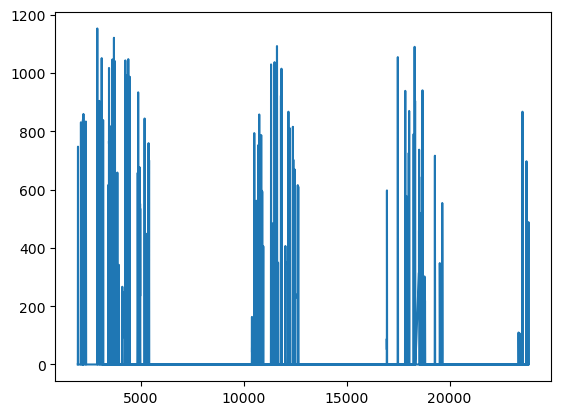

In [53]:
plt.plot(val_B['pv_measurement'], label='A')
plt.show()

In [54]:
# Inspect data
X_train_A.columns

Index(['total_radiation:W', 'total_radiation_1h:J', 'snow_accumulation',
       'super_cooled_liquid_water:kgm2', 'average_wind_speed',
       'sun_elevation:d', 'sun_azimuth:d', 'clear_sky_rad:W', 'month',
       't_1000hPa:C', 'msl_pressure:hPa_scaled', 'rain_water:kgm2',
       'cloud_base_agl:m', 'effective_cloud_cover:p', 'dew_or_rime:idx'],
      dtype='object')

In [55]:
def custom_mae_objective(y_true, y_pred):
    """
    Custom objective function for XGBoost.
    Focuses on minimizing the MAE while penalizing under-predictions 1.3 times more than over-predictions.

    Parameters:
    y_true (array): The true values.
    y_pred (array): The predicted values.

    Returns:
    grad (array): The gradient.
    hess (array): The Hessian (second derivative).
    """
    # Calculate the residual (error)
    residual = y_pred - y_true

    # Define the factor for under-prediction penalty
    under_prediction_factor = 1.3

    # Gradient: 1 or -1 multiplied by the under_prediction_factor for under-predictions
    grad = np.where(residual < 0, -under_prediction_factor, 1)

    # Hessian: Set to a small constant value since the second derivative of MAE is zero
    # (This is a common practice for handling MAE in gradient boosting)
    hess = np.ones_like(y_pred) * 0.1

    return grad, hess


In [56]:
# Store evaluation results in a dictionary
evals_result_A = {}
evals_result_B = {}
evals_result_C = {}

# Initalize the models
parameters_A = {
    'colsample_bytree': 0.8, 
    'gamma': 0.4, 
    'learning_rate': 0.012, 
    'max_depth': 15, 
    'min_child_weight': 10, 
    'n_estimators': 600, 
    'reg_alpha': 0.8, 
    'reg_lambda': 0.8, 
    'subsample': 0.912,
    'random_state': 0, 
    'booster': 'gbtree',
    'n_jobs': -1,
    'eval_set': [(X_train_A, y_train_A), (X_val_A, y_val_A)],
    'num_parallel_tree': 5
}

parameters_B = {
    'colsample_bytree': 0.8, 
    'gamma': 0.8, 
    'learning_rate': 0.008, 
    'max_depth': 15, 
    'min_child_weight': 10, 
    'n_estimators': 600, 
    'reg_alpha': 1, 
    'reg_lambda': 3, 
    'subsample': 0.912,
    'random_state': 0, 
    'booster': 'gbtree',
    'n_jobs': -1,
    'eval_set': [(X_train_B, y_train_B), (X_val_B, y_val_B)]
}

parameters_C = {
    'colsample_bytree': 0.8, 
    'gamma': 0.8, 
    'learning_rate': 0.008, 
    'max_depth': 15, 
    'min_child_weight': 10, 
    'n_estimators': 600, 
    'reg_alpha': 1, 
    'reg_lambda': 3, 
    'subsample': 0.912,
    'random_state': 0, 
    'booster': 'gbtree',
    'n_jobs': -1,
    'eval_set': [(X_train_C, y_train_C), (X_val_C, y_val_C)]
}


tscv = TimeSeriesSplit(n_splits=10)
model_A = xgb.XGBRegressor(**parameters_A)
model_B = xgb.XGBRegressor(**parameters_B)
model_C = xgb.XGBRegressor(**parameters_C)

In [57]:
# Fit the models, verbose=False
model_A.fit(
    X=X_train_A, y=y_train_A,
    eval_set=[(X_train_A, y_train_A), (X_val_A, y_val_A)],
    eval_metric='mae',
    verbose=False
)

model_B.fit(
    X=X_train_B, y=y_train_B,
    eval_set=[(X_train_B, y_train_B), (X_val_B, y_val_B)],
    eval_metric='mae',
    verbose=False
)

model_C.fit(
    X=X_train_C, y=y_train_C,
    eval_set=[(X_train_C, y_train_C), (X_val_C, y_val_C)],
    eval_metric='mae',
    verbose=False
)

[18:15:29] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "eval_set" } are not used.

[18:20:49] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "eval_set" } are not used.

[18:22:08] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_21wtzqx5vy/croot/xgboost-split_1675457780668/work/src/learner.cc:767: 
Parameters: { "eval_set" } are not used.



XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             eval_set=[(      total_radiation:W  total_radiation_1h:J  snow_accumulation  \
3952                0.0              0.000000                0.0   
3953                0.0              0.000000                0.0   
3954                0.0              0.000000                0.0   
3955                0.0              0.000000                3.5   
3956                1.4           2520.8999...
             feature_types=None, gamma=0.8, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.008, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
             max_leaves=None, min_child_weight=10, missing=nan,
             monotone_constraints=None, n_estimators=600, n_jobs=-1,
             num_parallel_tree=None, predictor=None, ...)

In [58]:
# Mean absolute error
print('MAE A:', mean_absolute_error(y_val_A, model_A.predict(X_val_A)))
print('MAE B:', mean_absolute_error(y_val_B, model_B.predict(X_val_B)))
print('MAE C:', mean_absolute_error(y_val_C, model_C.predict(X_val_C)))

# Total MAE for all three locations
print('Total MAE:', (mean_absolute_error(y_val_A, model_A.predict(X_val_A)) + mean_absolute_error(y_val_B, model_B.predict(X_val_B)) + mean_absolute_error(y_val_C, model_C.predict(X_val_C)))/3)

# Mean error
print('ME A:', np.mean(y_val_A - model_A.predict(X_val_A)))
print('ME B:', np.mean(y_val_B - model_B.predict(X_val_B)))
print('ME C:', np.mean(y_val_C - model_C.predict(X_val_C)))

# Total ME for all three locations
print('Total ME:', (np.mean(y_val_A - model_A.predict(X_val_A)) + np.mean(y_val_B - model_B.predict(X_val_B)) + np.mean(y_val_C - model_C.predict(X_val_C)))/3)

# Without total_radiation:W
# MAE A: 314.7580523931966
# MAE B: 63.681887486133554
# MAE C: 49.851182439343
# Total MAE: 142.76370743955772

# With total_radiation:W
# MAE A: 291.82490464357284
# MAE B: 66.04321649378976
# MAE C: 47.403692720066566
# Total MAE: 135.09060461914305

# Best score columns
# MAE A: 309.0826616675123
# MAE B: 64.06956132854198
# MAE C: 53.22038451291638
# Total MAE: 142.12420250299022
# ME A: 7.267573769838339
# ME B: 14.965701411421241
# ME C: -1.6131347546010604
# Total ME: 6.873380142219506

# Best score columns + total_radiation_1h:J
# MAE A: 302.93721044019435
# MAE B: 63.94798590952591
# MAE C: 50.512837413778804
# Total MAE: 139.13267792116636
# ME A: 35.11670474576242
# ME B: 14.960414421668336
# ME C: 9.975241619749697
# Total ME: 20.017453595726817

# MAE A: 308.6544953352312
# MAE B: 66.25132875821835
# MAE C: 44.15307500269213
# Total MAE: 139.6862996987139
# ME A: 24.62190151984494
# ME B: -0.6224847480832405
# ME C: 1.0602988101647328
# Total ME: 8.35323852730881

# MAE A: 324.04982244033044
# MAE B: 66.6021787883337
# MAE C: 46.04289283240646
# Total MAE: 145.56496468702355
# ME A: 20.15437223878788
# ME B: 2.2412311917624717
# ME C: 9.495809591591406
# Total ME: 10.630471007380587

# MAE A: 284.9102196304451
# MAE B: 62.23843992362985
# MAE C: 49.43394351729261
# Total MAE: 132.1942010237892
# ME A: 46.18828156380829
# ME B: -4.57088628422224
# ME C: -5.455840858607711
# Total ME: 12.053851473659444

# After tuning
# MAE A: 317.04072348880254
# MAE B: 65.00165208045622
# MAE C: 46.35594399417613
# Total MAE: 142.7994398544783
# ME A: -15.427089619992312
# ME B: 7.845440177310691
# ME C: 6.9280891490883
# Total ME: -0.21785343119777364

# MAE A: 307.11370804199987
# MAE B: 67.91418938891736
# MAE C: 49.11264133268743
# Total MAE: 141.3801795878682
# ME A: 16.035510342448784
# ME B: 5.314661002390436
# ME C: 5.90268905623938
# Total ME: 9.084286800359534

# MAE A: 317.47864263867046
# MAE B: 63.39625235989378
# MAE C: 49.6123831696463
# Total MAE: 143.4957593894035
# ME A: 18.754913004418125
# ME B: 2.0429128090352724
# ME C: 1.1224240538299033
# Total ME: 7.3067499557610995

# MAE A: 327.3348764329256
# MAE B: 68.95020985898239
# MAE C: 50.57612520972816
# Total MAE: 148.95373716721204
# ME A: -7.012042550964539
# ME B: -1.091123722963018
# ME C: 8.19633503560465
# Total ME: 0.031056253892364438

# MAE A: 318.43778894920445
# MAE B: 63.702040953133775
# MAE C: 51.85193338341636
# Total MAE: 144.6639210952515
# ME A: 4.089304098125822
# ME B: 3.3185883005206023
# ME C: -3.6432487790040926
# Total ME: 1.254881206547444


MAE A: 318.43778894920445
MAE B: 63.702040953133775
MAE C: 51.85193338341636
Total MAE: 144.6639210952515
ME A: 4.089304098125822
ME B: 3.3185883005206023
ME C: -3.6432487790040926
Total ME: 1.254881206547444


In [59]:
# Feature importance
feature_importances = model_A.feature_importances_
feature_importances = pd.DataFrame({'feature': list(X_train_A.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)

# Print feature importance
for i in range(feature_importances.shape[0]):
    print(f"{i} {feature_importances.iloc[i, 0]}: {feature_importances.iloc[i, 1]}")

0 total_radiation:W: 0.5389741063117981
1 total_radiation_1h:J: 0.2516215145587921
2 clear_sky_rad:W: 0.03529762476682663
3 snow_accumulation: 0.026070132851600647
4 effective_cloud_cover:p: 0.020824553444981575
5 sun_azimuth:d: 0.01710251346230507
6 month: 0.016077406704425812
7 msl_pressure:hPa_scaled: 0.015239790081977844
8 average_wind_speed: 0.015115959569811821
9 rain_water:kgm2: 0.01412811130285263
10 t_1000hPa:C: 0.013048311695456505
11 sun_elevation:d: 0.013031325303018093
12 cloud_base_agl:m: 0.012204050086438656
13 super_cooled_liquid_water:kgm2: 0.011263898573815823
14 dew_or_rime:idx: 6.654178150711232e-07


In [60]:
# Create submission

output_file = 'xgb_submission.csv'

pred_A = model_A.predict(test_A)
pred_B = model_B.predict(test_B)
pred_C = model_C.predict(test_C)

pred_A = np.clip(pred_A, 0, None)
pred_B = np.clip(pred_B, 0, None)
pred_C = np.clip(pred_C, 0, None)

# Concatenate predictions
predictions = np.concatenate([pred_A, pred_B, pred_C])

# Create an id array
ids = np.arange(0, len(predictions))

# Create a DataFrame
df = pd.DataFrame({
    'id': ids,
    'prediction': predictions
})

# Save to CSV
df.to_csv(output_file, index=False)
print(f"Submission saved to {output_file}")

Submission saved to xgb_submission.csv


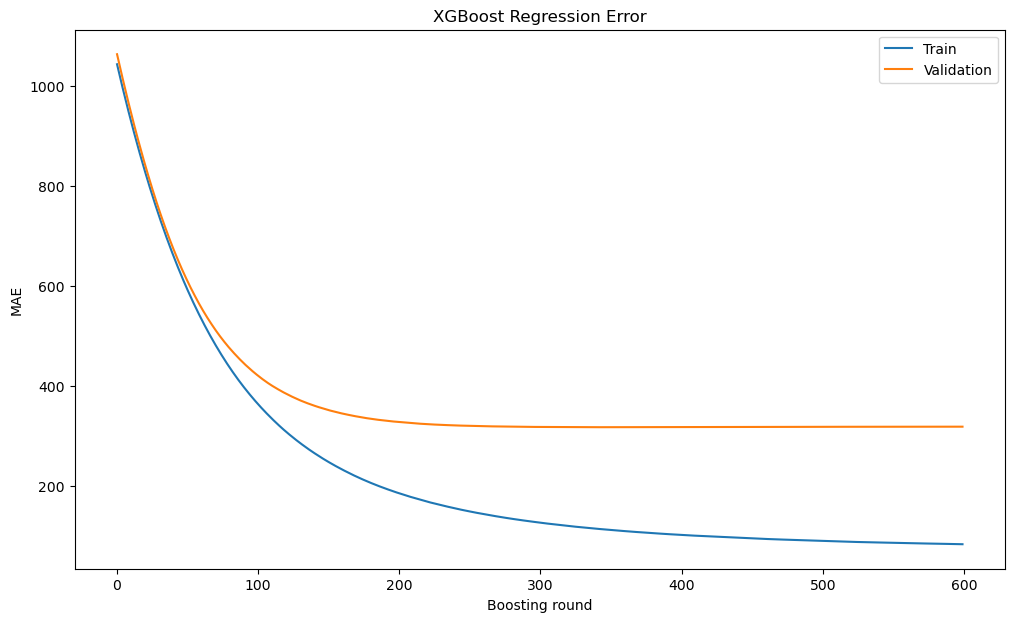

In [61]:
evals_result_A = model_A.evals_result()
evals_result_B = model_B.evals_result()
evals_result_C = model_C.evals_result()

train_error_A = evals_result_A['validation_0']['mae']
val_error_A = evals_result_A['validation_1']['mae']
train_error_B = evals_result_B['validation_0']['mae']
val_error_B = evals_result_B['validation_1']['mae']
train_error_C = evals_result_C['validation_0']['mae']
val_error_C = evals_result_C['validation_1']['mae']

epochs = len(train_error_A)
x_axis = range(0, epochs)

# Plot for model A
plt.figure(figsize=(12, 7))
plt.plot(x_axis, train_error_A, label='Train')
plt.plot(x_axis, val_error_A, label='Validation')
plt.legend()

plt.ylabel('MAE')
plt.xlabel('Boosting round')
plt.title('XGBoost Regression Error')
plt.show()


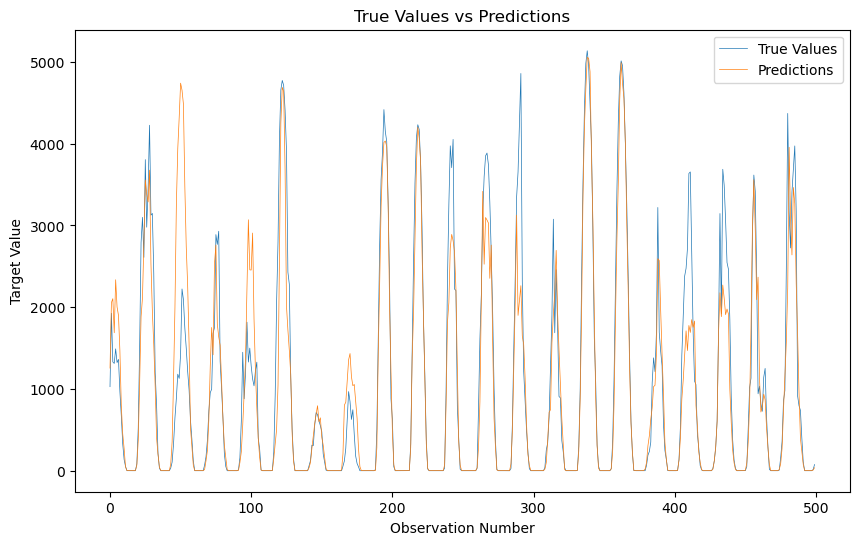

In [62]:
start = 2000
stop = 2500

plt.figure(figsize=(10, 6))
plt.plot(y_val_A[start:stop].reset_index(drop=True), label='True Values', linewidth=0.5)
plt.plot(model_A.predict(X_val_A[start:stop]), label='Predictions', linewidth=0.5)
plt.title('True Values vs Predictions')
plt.xlabel('Observation Number')
plt.ylabel('Target Value')
plt.legend()
plt.savefig('true_vs_pred.png')
plt.show()

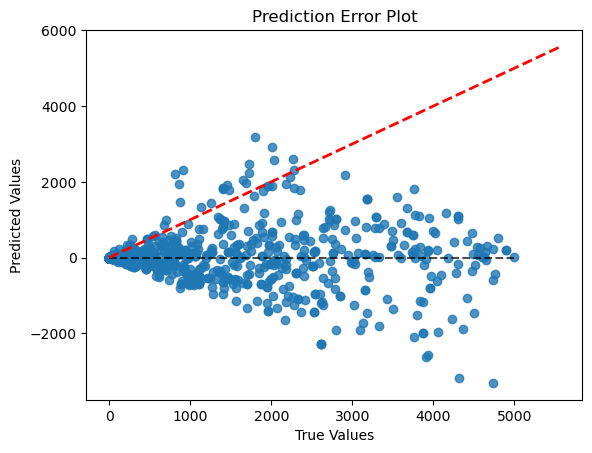

In [63]:
pred_A = model_A.predict(X_val_A)
fig, ax = plt.subplots()
PredictionErrorDisplay.from_predictions(y_val_A, pred_A, ax=ax)
ax.plot([y_val_A.min(), y_val_A.max()], [y_val_A.min(), y_val_A.max()], '--r', linewidth=2)
ax.set_title('Prediction Error Plot')
ax.set_xlabel('True Values')
ax.set_ylabel('Predicted Values')
plt.show()

In [64]:
graphviz = to_graphviz(model_A, num_trees=0)

# To save the visualization to a file, you can use the .render() method
graphviz.render('xgboost_tree')

'xgboost_tree.pdf'

# Features in the best prediction 154 MAE

0 total_radiation: 0.4234558045864105 \
1 direct_rad:W: 0.2128763496875763 \
2 direct_rad_1h:J: 0.0615650974214077 \
3 total_radiation_rolling_avg_3: 0.03578149154782295 \
4 diffuse_rad:W: 0.02013232931494713 \
5 clear_sky_rad:W: 0.013245003297924995 \
6 snow_accumulation: 0.012912849895656109 \
7 sun_azimuth:d_lag_7: 0.010069170035421848 \
8 sun_elevation:d: 0.009076440706849098 \
9 relative_humidity_1000hPa:p_lag_-3: 0.006535227410495281 \
10 sun_azimuth:d: 0.005778656806796789 \
11 diffuse_rad_1h:J: 0.00557068781927228 \
12 temp_dewpoint_diff_lag_-4: 0.0054164547473192215 \
13 clear_sky_rad:W_rate_of_change: 0.005305740050971508 \
14 effective_cloud_cover:p: 0.005097666289657354 \
15 hour: 0.005087343044579029 \
16 date_forecast_fft_amplitude: 0.004949505440890789 \
17 clear_sky_energy_1h:J: 0.004622776992619038 \
18 msl_pressure:hPa_lag_3: 0.004557096865028143 \
19 t_1000hPa:K_rolling_avg_24: 0.004549496807157993 \
20 total_cloud_cover:p: 0.004411020781844854 \
21 visibility:m_lag_-2: 0.00400067213922739 \
22 total_radiation_rate_of_change: 0.003874964313581586 \
23 month: 0.0038293872494250536 \
24 sfc_pressure:hPa: 0.0038288664072752 \
25 average_wind_speed: 0.0038149317260831594 \
26 t_1000hPa:K_lag_4: 0.003787972265854478 \
27 sun_elevation:d_fft_phase: 0.0037678431253880262 \
28 pressure_50m:hPa: 0.0037581848446279764 \
29 msl_pressure:hPa_rolling_avg_24: 0.00369848869740963 \
30 dew_point_2m:K_lag_19: 0.0035477483179420233 \
31 t_1000hPa:K: 0.0035387056414037943 \
32 pressure_100m:hPa: 0.003512951312586665 \
33 total_cloud_cover:p_rolling_avg_6: 0.003464051755145192 \
34 direct_rad:W_rate_of_change: 0.003448427189141512 \
35 dew_point_2m:K: 0.003425233531743288 \
36 absolute_humidity_2m:gm3_rolling_avg_24: 0.003379648318514228 \
37 pressure_gradient: 0.0033784068655222654 \
38 sfc_pressure:hPa_lag_8: 0.003355256747454405 \
39 sun_elevation:d_fft_amplitude: 0.0033312165178358555 \
40 year: 0.003244817489758134 \
41 wind_vector_magnitude: 0.003148019313812256 \
42 date_forecast_fft_phase: 0.003074726788327098 \
43 absolute_humidity_2m:gm3: 0.003025446319952607 \
44 msl_pressure:hPa: 0.003022641409188509 \
45 t_1000hPa:K_rate_of_change: 0.003010170767083764 \
46 effective_cloud_cover:p_rate_of_change: 0.0029358689207583666 \
47 clear_sky_rad:W_rate_of_change_of_change: 0.002842330140992999 \
48 effective_cloud_cover:p_rolling_avg_6: 0.002791582839563489 \
49 clear_sky_rad:W_rolling_avg_6: 0.002718282165005803 \
50 total_cloud_cover:p_rate_of_change: 0.0026860570069402456 \
51 observed: 0.0026119498070329428 \
52 wind_vector_magnitude_lag_8: 0.002609953982755542 \
53 temp_dewpoint_diff: 0.002551795681938529 \
54 total_radiation_rate_of_change_of_change: 0.0025030174292623997 \
55 direct_rad:W_rate_of_change_of_change: 0.00249316799454391 \
56 relative_humidity_1000hPa:p: 0.00249219941906631 \
57 total_cloud_cover:p_rate_of_change_of_change: 0.002429977525025606 \
58 diffuse_rad:W_rate_of_change: 0.0024279451463371515 \
59 sun_elevation:d_rolling_avg_6: 0.0023145817685872316 \
60 visibility:m: 0.002289965283125639 \
61 dew_point_2m:K_rate_of_change: 0.0022229659371078014 \
62 dew_point_2m:K_rate_of_change_of_change: 0.002219223417341709 \
63 effective_cloud_cover:p_rate_of_change_of_change: 0.002212965628132224 \
64 dew_or_rime:idx_lag_11: 0.0021920606959611177 \
65 t_1000hPa:K_rate_of_change_of_change: 0.0020750060211867094 \
66 diffuse_rad:W_rate_of_change_of_change: 0.0020208051428198814 \
67 is_in_shadow:idx: 7.590975292259827e-05 \
68 is_day:idx: 1.739487561280839e-05 \
69 prob_rime:p: 0.0 \